# Exploratory Data Analysis (EDA) in SQL

## 0. Imports and helper functions

In [1]:
import csv
import pandas as pd
import sqlite3

import requests
from PIL import Image
from io import BytesIO
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
def fetch(query, conn, formatted=True):
    # execute the query and fetch all rows
    cur = conn.cursor()
    cur.execute(query)
    rs = cur.fetchall()
    
    # extract column names from the cursor description
    columns = [desc[0] for desc in cur.description]
    
    # return a dataframe with column names
    return pd.DataFrame(rs, columns=columns) if formatted else rs

def show_tables(conn):
    return [x[0] for x in fetch('SELECT tbl_name FROM sqlite_master WHERE type="table"', conn, False)]

def shape(table, conn):
    nrows = fetch(f'SELECT COUNT(*) FROM {table}', conn, False)[0][0]
    ncols = fetch(f'SELECT COUNT(*) FROM pragma_table_info("{table}")', conn, False)[0][0]

    return (nrows, ncols)

def desc(table, conn):
    cur = conn.cursor()
    cur.execute(f'PRAGMA table_info("{table}")')
    columns = [row[1] for row in cur.fetchall()]
    
    return columns

def info(table, conn):
    # table constraints (domain, null, default, pk)
    df1 = fetch(f'PRAGMA table_info("{table}")', conn)
    columns = desc(table, conn)
    
    # entries per column
    counts = ', '.join([f'COUNT(*) AS "{column}"' for column in columns])
    df2 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df2.columns = ['count']
    
    # non-null entries per column
    counts = ', '.join([f'COUNT("{column}") AS "{column}"' for column in columns])
    df3 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df3.columns = ['notnull count']

    # unique non-null entries per column
    counts = ', '.join([f'COUNT(DISTINCT "{column}") AS "{column}"' for column in columns])
    df4 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df4.columns = ['unique count']
    
    return df1.merge(df2, left_on='name', right_index=True) \
            .merge(df3, left_on='name', right_index=True) \
            .merge(df4, left_on='name', right_index=True)

def display(urls, cols=5):
    # fetch images
    images = []
    for url in urls:
        response = requests.get(url)
        if response.status_code == 200:
            images.append(Image.open(BytesIO(response.content)))

    # calculate the number of rows
    rows = (len(images) + cols - 1) // cols  
    fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

    for i, ax in enumerate(axs.flat):
        if i < len(images):
            ax.imshow(images[i])
            ax.axis("off")  # Hide axes
        else:
            ax.axis("off")  # Hide unused subplots
    plt.tight_layout()
    plt.show()

def hist(data, xlabel='', ylabel='', bins='auto'):
    # convert list of tuples into dataframe
    df = pd.DataFrame(data, columns=['key', 'frequency'])
    # expand the data based on frequencies
    expanded = df.loc[df.index.repeat(df['frequency'])].reset_index(drop=True)

    # plot histogram
    sns.histplot(expanded['key'], bins=bins, kde=False)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.show()

## 1. Data ingestion

In [3]:
# source dataset: https://www.kaggle.com/datasets/amanbarthwal/imdb-movies-data
source = 'imdb-movies-dataset.csv'

# connect to SQLite database
conn = sqlite3.connect('imdb-movies.db')
cur = conn.cursor()

# set PRAGMA options for faster ingestion
cur.execute('PRAGMA synchronous = OFF')
cur.execute('PRAGMA journal_mode = MEMORY')

# batch size for processing large datasets
BATCH_SIZE = 1000

# begin transaction for bulk ingestion
cur.execute('BEGIN TRANSACTION')

# read the CSV file and ingest in batches
with open(source, 'r') as f:
    reader = csv.reader(f)
    header = next(reader)  # Read the header row

    # create table with appropriate column names
    columns = [f'"{column}"' for column in header]
    create = f'CREATE TABLE IF NOT EXISTS Source ({", ".join(columns)})'
    cur.execute(create)

    # prepare the INSERT query
    placeholders = ', '.join(['?'] * len(header))
    insert = f'INSERT INTO Source VALUES ({placeholders})'

    # process rows in batches
    batch = []
    for row in reader:
        batch.append(row)
        if len(batch) == BATCH_SIZE:
            # Execute batch insert
            cur.executemany(insert, batch)
            # Reset batch
            batch = []

    # insert any remaining rows
    if batch:
        cur.executemany(insert, batch)

# nullify empty values, so they are recognized as proper nulls
update = f'UPDATE Source SET ' + ','.join([f'{column} = NULLIF({column}, "")' for column in columns])
cur.execute(update)

# commit changes
conn.commit()

# reset PRAGMA options (optional but recommended for safety)
cur.execute('PRAGMA synchronous = FULL')
cur.execute('PRAGMA journal_mode = DELETE')

## 2. Data understanding

In [4]:
# show tables
show_tables(conn)

['Source']

In [5]:
# get table shape -- analogous to pandas' shape
shape('Source', conn)

(10000, 15)

In [6]:
# info table -- analogous to pandas' .info() / .nunique()
info('Source', conn)

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,Poster,,0,None,0,10000,10000,9862
1,1,Title,,0,None,0,10000,10000,9634
2,2,Year,,0,None,0,10000,9850,60
3,3,Certificate,,0,None,0,10000,7370,30
4,4,Duration (min),,0,None,0,10000,9664,179
5,5,Genre,,0,None,0,10000,9993,475
6,6,Rating,,0,None,0,10000,9596,80
7,7,Metascore,,0,None,0,10000,7555,97
8,8,Director,,0,None,0,10000,9995,4549
9,9,Cast,,0,None,0,10000,9961,9906


In [7]:
# peek into some data

# first rows -- analogous to pandas' head()
fetch('SELECT * FROM Source ORDER BY "index" ASC LIMIT 2', conn)

# last rows -- analogous to pandas' tail()
fetch('SELECT * FROM Source ORDER BY "index" DESC LIMIT 2', conn)

# random rows -- analogous to pandas' sample()
fetch('SELECT * FROM Source ORDER BY random() LIMIT 5', conn)

,Poster,Title,Year,Certificate,Duration (min),Genre,Rating,Metascore,Director,Cast,Votes,Description,Review Count,Review Title,Review
0,https://m.media-amazon.com/images/M/MV5BMDE2MD...,Hercules in New York,2014,None,92,"Adventure, Comedy, Fantasy",3.3,23,Arthur Allan Seidelman,"Arnold Stang, Arnold Schwarzenegger, Deborah L...","19,620",Hercules is sent to Earth where he finds true ...,132,Arnold's First,I don't know if it wasn't meant to be but this...
1,https://m.media-amazon.com/images/M/MV5BMmQyMD...,Peter Pan,1985,U,113,"Adventure, Family, Fantasy",6.8,64,P.J. Hogan,"Jeremy Sumpter, Jason Isaacs, Olivia Williams,...","80,272",The Darling family children receive a visit fr...,458,"The best Peter Pan to date, unfortunately at t...",Up front I will say it: this is the best Peter...
2,https://m.media-amazon.com/images/M/MV5BMTQ2NT...,The Other Boleyn Girl,2023,A,115,"Biography, Drama, History",6.7,50,Justin Chadwick,"Natalie Portman, Scarlett Johansson, Eric Bana...","120,091",Two sisters contend for the affection of King ...,199,Eh... Nice costumes and sets,If you want a good movie about Henry VIII and ...
3,https://m.media-amazon.com/images/M/MV5BYWQ3MD...,99 Moons,2021,None,110,Drama,5.0,None,Jan Gassmann,"Valentina Di Pace, Dominik Fellmann, Danny Exn...","2,470",Bigna and Frank are two people of different th...,2,Equivalent to 99 balloons?,"Obviously not, but if you know the song by Nen..."
4,https://m.media-amazon.com/images/M/MV5BOGRjZT...,The Kentucky Fried Movie,2005,A,83,Comedy,6.4,61,John Landis,"Evan C. Kim, Bong Soo Han, Bill Bixby, George ...","20,294",The daily programming of a fictional local TV ...,132,"Tasteless, juvenile and very funny","A bunch of skits spoofing TV shows, commercial..."


## 3. Data cleaning

In [8]:
# impute averages for missing values (assume averages highly influenced by genres)
# -- analogous to pandas' fillna()

# Rating (float)
cur.execute('''UPDATE Source AS t1
               SET Rating = (
                 SELECT AVG(t2.Rating)
                 FROM Source AS t2 
                 WHERE t2.Genre = t1.Genre )
               WHERE t1.Rating IS NULL ''')

# Metascore (int)
cur.execute('''UPDATE Source AS t1
               SET Metascore = (
                 SELECT ROUND(AVG(t2.Metascore), 1) 
                 FROM Source AS t2 
                 WHERE t2.Genre = t1.Genre )
               WHERE t1.Metascore IS NULL ''')

# commit changes
conn.commit()

In [9]:
# drop all remaining missing values -- analogous to pandas' dropna()
drops = ' OR '.join([f'{column} IS NULL' for column in columns])
cur.execute(f'DELETE FROM Source WHERE {drops}')

# commit changes
conn.commit()

In [10]:
# info table after handling missing values
info('Source', conn)

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,Poster,,0,None,0,7190,7190,7190
1,1,Title,,0,None,0,7190,7190,6996
2,2,Year,,0,None,0,7190,7190,60
3,3,Certificate,,0,None,0,7190,7190,30
4,4,Duration (min),,0,None,0,7190,7190,153
5,5,Genre,,0,None,0,7190,7190,383
6,6,Rating,,0,None,0,7190,7190,75
7,7,Metascore,,0,None,0,7190,7190,240
8,8,Director,,0,None,0,7190,7190,3119
9,9,Cast,,0,None,0,7190,7190,7145


## 4. Univariate analysis

### Title

In [11]:
# get a distribution of movies per (title-induced) cluster size
fetch('''
SELECT "Cluster Size", COUNT(*) AS Movies
FROM (SELECT Title, COUNT(*) AS "Cluster Size" FROM Source GROUP BY Title)
GROUP BY "Cluster Size"
HAVING "Cluster Size"''', conn)

,Cluster Size,Movies
0,1,6811
1,2,176
2,3,9


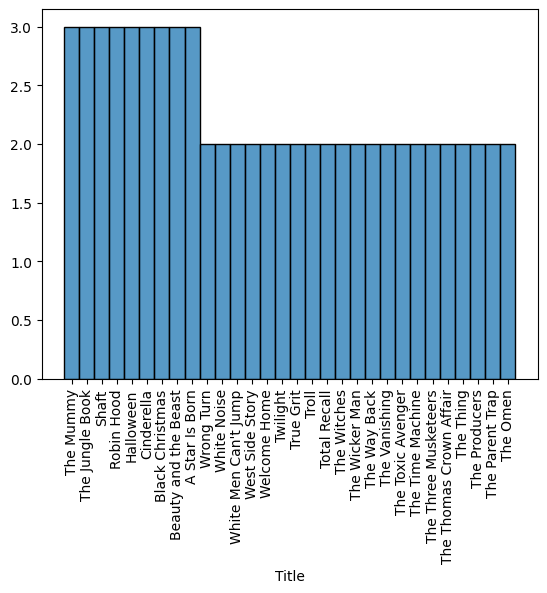

In [12]:
# get a distribution of movies per title
distro = fetch('SELECT Title, COUNT(*) AS Frequency FROM Source GROUP BY Title HAVING Frequency > 1 ORDER BY Frequency DESC LIMIT 30', conn, False)

# plot histogram
hist(distro, xlabel='Title')

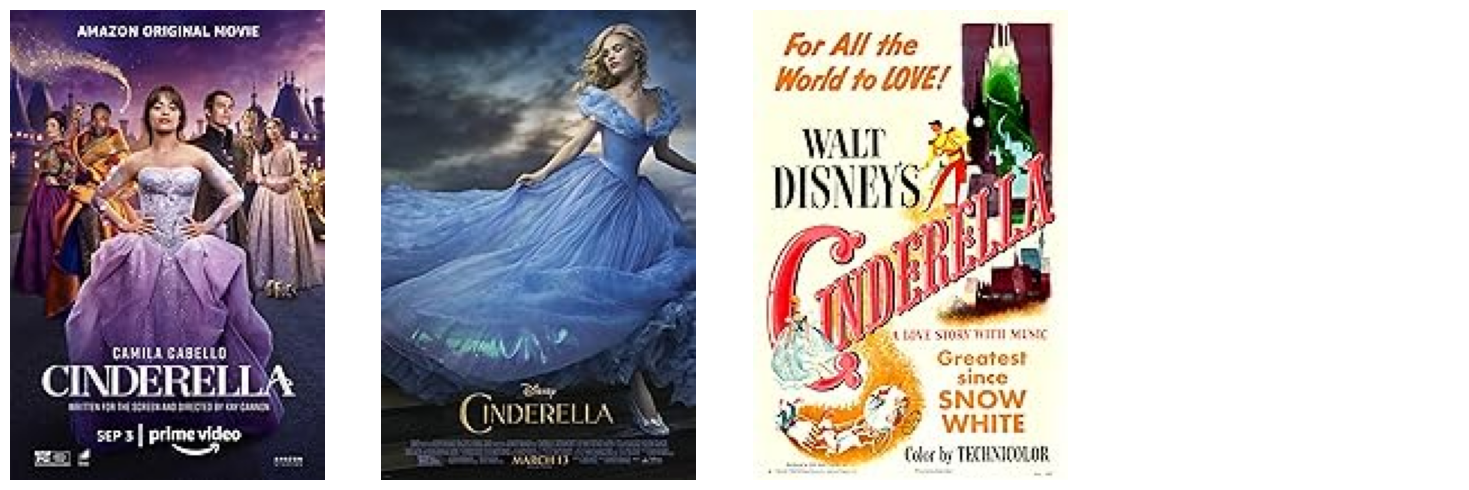

In [13]:
# titles should be unique in principle;
# check whether duplicates are genuine or just "homonyms"
# (use posters to disambiguate)
urls = [row[0] for row in fetch('''
SELECT Poster FROM Source WHERE Title IN
(SELECT Title FROM Source
 GROUP BY Title HAVING COUNT(*) > 2
 ORDER BY random() LIMIT 1)
 ''', conn, False)]

display(urls, 4)

### Year

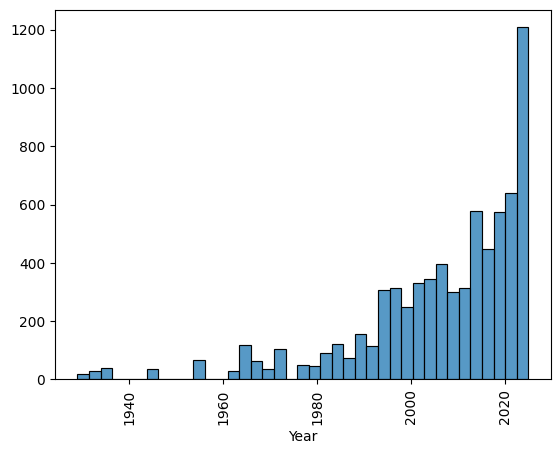

In [14]:
# get a distribution of movies per year
distro = fetch('SELECT CAST(Year AS INT) AS Year, COUNT(*) AS Frequency FROM Source GROUP BY Year ORDER BY Year', conn, False)

# plot histogram
hist(distro, xlabel='Year')

### Certificate

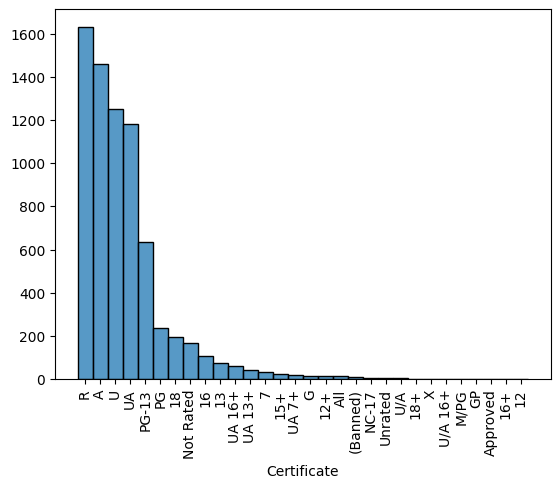

In [15]:
# get a distribution of movies per certificate
data = fetch('SELECT Certificate, COUNT(*) AS Frequency FROM Source GROUP BY Certificate ORDER BY Frequency DESC', conn, False)

# plot histogram
hist(data, xlabel='Certificate')

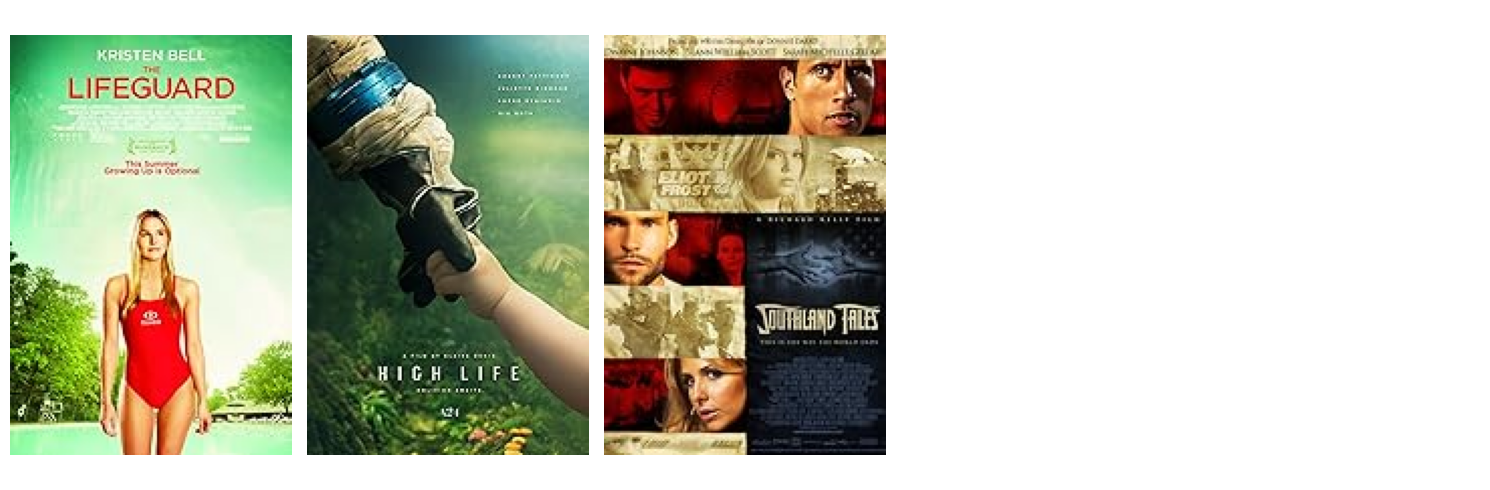

In [16]:
# high frequency of R-rated movies seems weird, could this be wrongly labeled? let's double-check
urls = [row[0] for row in fetch('''
    SELECT Poster FROM Source WHERE Certificate = "R" ORDER BY random() LIMIT 5''', conn, False)]
display(urls, 5)

### Genre

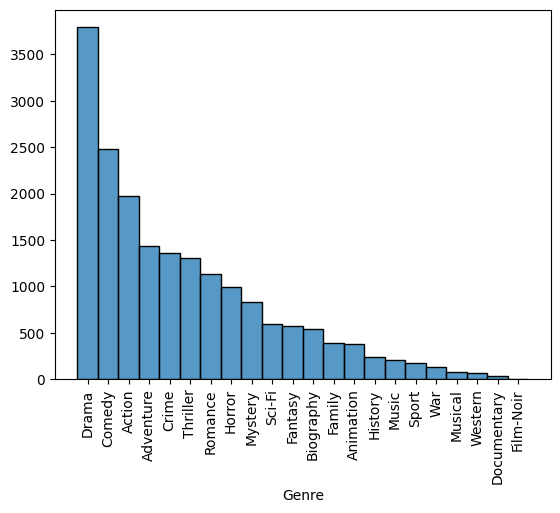

In [17]:
# get list of list of genre per movie
rows = fetch('SELECT Genre FROM Source', conn, False)
# flatten into list of genre
genres = [genre for genres in [row[0].split(', ') for row in rows] for genre in genres]
# turn into a distribution of genre
distro = list(sorted(Counter(genres).items(), key=lambda x: x[1], reverse=True))

# plot histogram
hist(distro, xlabel='Genre')

### Director

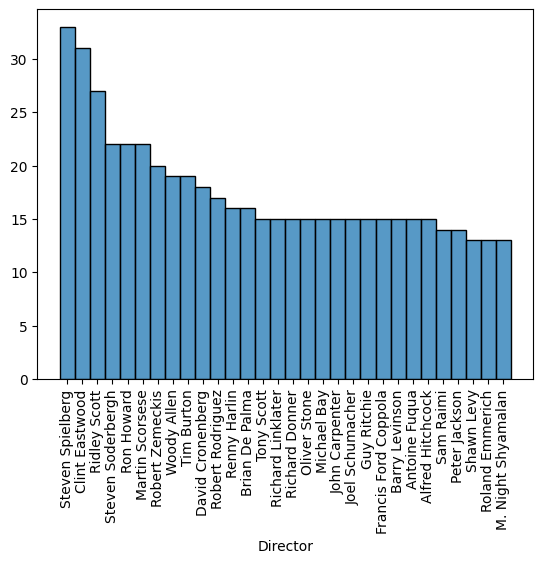

In [18]:
# get a distribution of movies per director
distro = fetch('SELECT Director, COUNT(*) AS Frequency FROM Source GROUP BY Director ORDER BY Frequency DESC LIMIT 30', conn, False)

# plot histogram
hist(distro, xlabel='Director')

### Cast

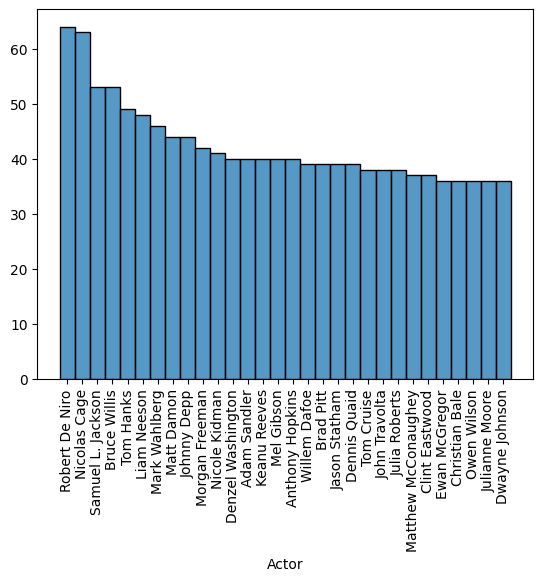

In [19]:
# get list of list of actor per movie
rows = fetch('SELECT "Cast" FROM Source', conn, False)
# flatten into list of actor
actors = [actor for actors in [row[0].split(', ') for row in rows] for actor in actors]
# turn into a distribution of genre, cap at top 30
distro = list(sorted(Counter(actors).items(), key=lambda x: x[1], reverse=True))[:30]

# plot histogram
hist(distro, xlabel="Actor")

### Rating

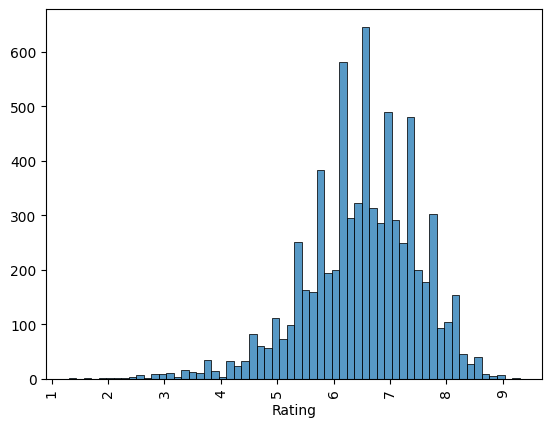

In [20]:
# get a distribution of movies per rating
distro = fetch('SELECT CAST(Rating AS FLOAT) AS Rating, COUNT(*) AS Frequency FROM Source GROUP BY Rating ORDER BY Rating', conn, False)

# plot histogram
hist(distro, xlabel='Rating')

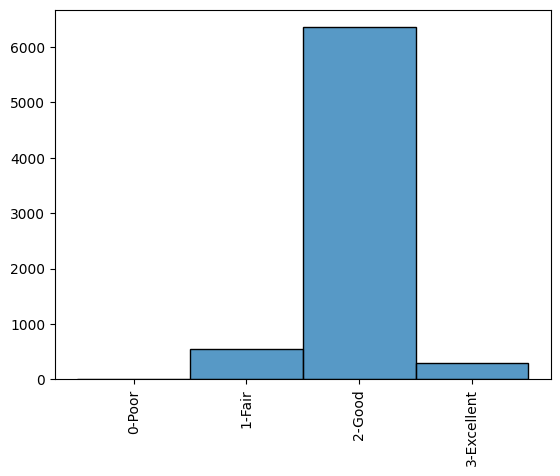

In [21]:
# get a discretized distribution (aka hard-coded bins)
# * 0–2: Poor
# * 3–5: Fair
# * 6–8: Good
# * 9–10: Excellent

distro = fetch('''SELECT Category, COUNT(*) AS Frequency
                  FROM (SELECT CASE
                          WHEN CAST(Rating AS Float) <= 2 THEN "0-Poor"
                          WHEN CAST(Rating AS Float) <= 5 THEN "1-Fair"
                          WHEN CAST(Rating AS Float) <= 8 THEN "2-Good"
                          ELSE "3-Excellent" END AS Category
                        FROM Source)
                  GROUP BY Category''', conn, False)

hist(distro)

### Review count

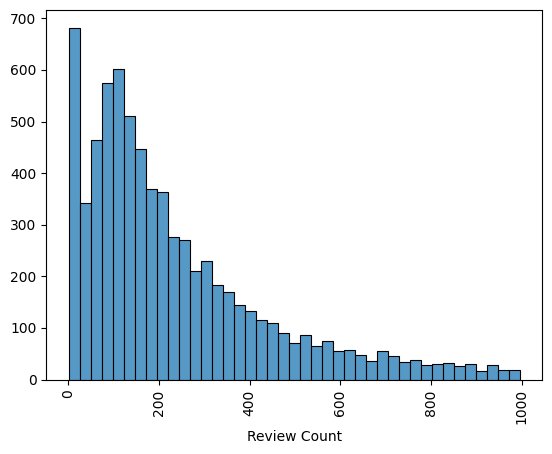

In [23]:
# get a distribution of movies per review count
distro = fetch('SELECT CAST("Review Count" AS INT) AS "Review Count", COUNT(*) AS Frequency FROM Source GROUP BY "Review Count" ORDER BY "Review Count"', conn, False)

# plot histogram
hist(distro, xlabel='Review Count')

## 5. Normalization

### Key observations

1. Dataset centered around movies -> create a PK
2. No attribute with a defined type -> set appropriate domain constraints
3. Genre and Cast are multivalued -> normalize into separate tables
4. Movie n:1 Director (evidence: common sense) -> normalize into separate tables
5. Movie 1:n Review (evidence: see Review Count) -> normalize into separate tables

### Data migration

#### Prepare source and target schemas

In [24]:
# prepare source schema
# add MovieID to serve as a unique reference for each row

ddl = [
    'ALTER TABLE Source ADD COLUMN MovieID INTEGER;',
    'UPDATE Source SET MovieID = rowid;'
]

for q in ddl:
    cur.execute(q)

# commit changes
conn.commit()

In [25]:
# prepare target schema
# define domain, not null, primary key, and foreign key constraints

ddl = [
    '''
    CREATE TABLE IF NOT EXISTS Movie (
        MovieID INTEGER PRIMARY KEY,
        MoviePoster TEXT,
        MovieTitle TEXT NOT NULL,
        MovieYear INTEGER NOT NULL,
        MovieCertificate TEXT,
        MovieDuration INTEGER,
        MovieDescription TEXT,
        MovieRating REAL,
        MovieMetascore INTEGER,
        MovieVotes INTEGER,
        MovieReviews INTEGER,
        DirectorID INTEGER NOT NULL,
        FOREIGN KEY (DirectorID) REFERENCES Director(DirectorID)
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Director (
        DirectorID INTEGER PRIMARY KEY,
        DirectorName TEXT NOT NULL
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Actor (
        ActorID INTEGER PRIMARY KEY,
        ActorName TEXT NOT NULL
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Casting (
        MovieID INTEGER NOT NULL,
        ActorID INTEGER NOT NULL,
        PRIMARY KEY (MovieID, ActorID),
        FOREIGN KEY (MovieID) REFERENCES Movie(MovieID),
        FOREIGN KEY (ActorID) REFERENCES Actor(ActorID)
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Genre (
        GenreID INTEGER PRIMARY KEY,
        GenreName TEXT NOT NULL
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Classification (
        MovieID INTEGER NOT NULL,
        GenreID INTEGER NOT NULL,
        PRIMARY KEY (MovieID, GenreID),
        FOREIGN KEY (MovieID) REFERENCES Movie(MovieID),
        FOREIGN KEY (GenreID) REFERENCES Genre(GenreID)
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Review (
        ReviewID INTEGER PRIMARY KEY,
        ReviewTitle TEXT NOT NULL,
        ReviewBody TEXT NOT NULL,
        MovieID INTEGER NOT NULL,
        FOREIGN KEY (MovieID) REFERENCES Movie(MovieID)
    );
    '''
]

for q in ddl:
    cur.execute(q)

# commit changes
conn.commit()

In [26]:
show_tables(conn)

['Source',
 'Movie',
 'Director',
 'Actor',
 'Casting',
 'Genre',
 'Classification',
 'Review']

#### Migrate Director

In [27]:
# migrate Director

cur.execute('DELETE FROM Director')
cur.execute('''
INSERT INTO Director (DirectorName)
SELECT DISTINCT Director
    FROM Source
    WHERE Director IS NOT NULL
    ORDER BY Director''')

conn.commit()

info('Director', conn)

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,DirectorID,INTEGER,0,None,1,3119,3119,3119
1,1,DirectorName,TEXT,1,None,0,3119,3119,3119


#### Migrate Movie

In [28]:
# migrate Movie

cur.execute('DELETE FROM Movie')
cur.execute('''
INSERT INTO Movie (
    MovieID, MoviePoster, MovieTitle, MovieYear, MovieCertificate, MovieDuration, MovieDescription, MovieRating, MovieMetascore, MovieVotes, MovieReviews, DirectorID
)
SELECT
    MovieID, Poster, Title, Year, Certificate, "Duration (min)", Description, Rating, Metascore, Votes, "Review Count", DirectorID
FROM Source JOIN Director ON Source.Director = Director.DirectorName;''')

conn.commit()

info('Movie', conn)

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,MovieID,INTEGER,0,None,1,7190,7190,7190
1,1,MoviePoster,TEXT,0,None,0,7190,7190,7190
2,2,MovieTitle,TEXT,1,None,0,7190,7190,6996
3,3,MovieYear,INTEGER,1,None,0,7190,7190,60
4,4,MovieCertificate,TEXT,0,None,0,7190,7190,30
5,5,MovieDuration,INTEGER,0,None,0,7190,7190,153
6,6,MovieDescription,TEXT,0,None,0,7190,7190,7188
7,7,MovieRating,REAL,0,None,0,7190,7190,75
8,8,MovieMetascore,INTEGER,0,None,0,7190,7190,210
9,9,MovieVotes,INTEGER,0,None,0,7190,7190,7055


#### Migrate Actor and Casting

In [29]:
# prepare Actor view
view = """
WITH RECURSIVE ActorView AS (
    SELECT
        MovieID,
        TRIM(SUBSTR("Cast", 1, INSTR("Cast" || ',', ',') - 1)) AS ActorName,
        TRIM(SUBSTR("Cast", INSTR("Cast" || ',', ',') + 1)) AS remainder
    FROM
        Source
    WHERE
        "Cast" IS NOT NULL AND "Cast" != ""
    UNION ALL
    SELECT
        MovieID,
        TRIM(SUBSTR(remainder, 1, INSTR(remainder || ',', ',') - 1)) AS ActorName,
        TRIM(SUBSTR(remainder, INSTR(remainder || ',', ',') + 1)) AS remainder
    FROM
        ActorView
    WHERE
        remainder IS NOT NULL AND remainder != ""
)
"""

In [30]:
# migrate Actor

cur.execute('DELETE FROM Actor')
cur.execute(f'''
INSERT INTO Actor (ActorName)
{view}
SELECT DISTINCT ActorName
    FROM ActorView
    WHERE ActorName IS NOT NULL
    ORDER BY ActorName''')

conn.commit()

info('Actor', conn)

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,ActorID,INTEGER,0,None,1,11525,11525,11525
1,1,ActorName,TEXT,1,None,0,11525,11525,11525


In [31]:
# migrate Casting

cur.execute('DELETE FROM Casting')
cur.execute(f'''
INSERT INTO Casting (MovieID, ActorID)
{view}
SELECT DISTINCT MovieID, ActorID
    FROM Actor JOIN ActorView
        ON Actor.ActorName = ActorView.ActorName
''')

conn.commit()

info('Casting', conn)

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,MovieID,INTEGER,1,None,1,29444,29444,7190
1,1,ActorID,INTEGER,1,None,2,29444,29444,11525


In [32]:
# sanity check: who are the actors of MovieID 3654?
fetch('''
SELECT MovieID, ActorID, ActorName
FROM Casting NATURAL JOIN Actor
WHERE MovieID = 3654
''', conn)

,MovieID,ActorID,ActorName
0,3654,79,Adam Wingard
1,3654,1618,Calvin Lee Reeder
2,3654,1788,Chad Villella
3,3654,2567,David Bruckner
4,3654,3857,Glenn McQuaid
5,3654,4027,Hannah Fierman
6,3654,5203,Joe Swanberg
7,3654,5728,Justin Martinez
8,3654,6354,Lane Hughes
9,3654,8870,Radio Silence


In [33]:
# sanity check: who are the actors of MovieID 3654?
pd.set_option('display.max_colwidth', None)
fetch('SELECT "Cast" FROM Source WHERE MovieID = 3654', conn)

,Cast
0,"David Bruckner, Tyler Gillett, Justin Martinez, Glenn McQuaid, Radio Silence, Joe Swanberg, Chad Villella, Ti West, Adam Wingard, Calvin Lee Reeder, Lane Hughes, Adam Wingard, Hannah Fierman"


#### Migrate Genre and Classification

In [34]:
# prepare Genre view
view = """
WITH RECURSIVE GenreView AS (
    SELECT
        MovieID,
        TRIM(SUBSTR("Genre", 1, INSTR("Genre" || ',', ',') - 1)) AS GenreName,
        TRIM(SUBSTR("Genre", INSTR("Genre" || ',', ',') + 1)) AS remainder
    FROM
        Source
    WHERE
        "Genre" IS NOT NULL AND "Genre" != ""
    UNION ALL
    SELECT
        MovieID,
        TRIM(SUBSTR(remainder, 1, INSTR(remainder || ',', ',') - 1)) AS GenreName,
        TRIM(SUBSTR(remainder, INSTR(remainder || ',', ',') + 1)) AS remainder
    FROM
        GenreView
    WHERE
        remainder IS NOT NULL AND remainder != ""
)
"""

In [35]:
# migrate Genre

cur.execute('DELETE FROM Genre')
cur.execute(f'''
INSERT INTO Genre (GenreName)
{view}
SELECT DISTINCT GenreName
    FROM GenreView
    WHERE GenreName IS NOT NULL
    ORDER BY GenreName''')

conn.commit()

info('Genre', conn)

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,GenreID,INTEGER,0,None,1,22,22,22
1,1,GenreName,TEXT,1,None,0,22,22,22


In [36]:
# migrate Classification

cur.execute('DELETE FROM Classification')
cur.execute(f'''
INSERT INTO Classification (MovieID, GenreID)
{view}
SELECT DISTINCT MovieID, GenreID
    FROM Genre JOIN GenreView
        ON Genre.GenreName = GenreView.GenreName
''')

conn.commit()

info('Classification', conn)

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,MovieID,INTEGER,1,None,1,18713,18713,7190
1,1,GenreID,INTEGER,1,None,2,18713,18713,22


In [37]:
# sanity check: what are the genres of MovieID 3654?
fetch('''
SELECT MovieID, GenreID, GenreName
FROM Classification NATURAL JOIN Genre
WHERE MovieID = 3654
''', conn)

,MovieID,GenreID,GenreName
0,3654,13,Horror
1,3654,16,Mystery
2,3654,20,Thriller


In [38]:
# sanity check: who are the actors of MovieID 3654?
pd.set_option('display.max_colwidth', None)
fetch('SELECT Genre FROM Source WHERE MovieID = 3654', conn)

,Genre
0,"Horror, Mystery, Thriller"


#### Migrate Review

In [39]:
# migrate Review

cur.execute('DELETE FROM Review')
cur.execute(f'''
INSERT INTO Review (ReviewTitle, ReviewBody, MovieID)
SELECT "Review Title", Review, MovieID
FROM Source
''')

conn.commit()

info('Review', conn)

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,ReviewID,INTEGER,0,None,1,7190,7190,7190
1,1,ReviewTitle,TEXT,1,None,0,7190,7190,7022
2,2,ReviewBody,TEXT,1,None,0,7190,7190,7190
3,3,MovieID,INTEGER,1,None,0,7190,7190,7190


#### Clean up

In [40]:
# drop source table
cur.execute('DROP TABLE Source;')
conn.commit()

show_tables(conn)

['Movie', 'Director', 'Actor', 'Casting', 'Genre', 'Classification', 'Review']

In [41]:
# close cursor and connection
cur.close()
conn.close()